In [1]:
import scanpy as sc
from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.0 pandas==1.5.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


# Load Spectrum Data and Embedding

In [2]:
url = "https://drive.google.com/uc?id=1alYWBGAa72jWpf7XFkeWOYEFgRnijpEs"
output = 'spectrum_all_adnexa_bowel.h5ad'
if not os.path.exists("spectrum_all_adnexa_bowel.h5ad"):
    gdown.download(url, output, quiet=False)

adata = sc.read("spectrum_all_adnexa_bowel.h5ad")

/Users/ceglian/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


26

In [7]:
dataset = GeneVectorDataset(adata)


Loading Expression.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 24578552/24578552 [03:45<00:00, 109061.38it/s]


Reindexing Cooc


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270833/270833 [00:05<00:00, 49379.20it/s]


In [8]:
cmps = GeneVector(dataset,
                  output_file="spectrum_all_samples.vec",
                  batch_size=100000000,
                  c=100.,
                  emb_dimension=100)

Generating inputs and outputs.


  0%|▏                                                                                                                   | 757/538203 [00:00<06:40, 1342.43it/s]/Users/ceglian/miniconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in true_divide
  hist /= s
100%|█████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [00:00<00:00, 1914.43it/s]


In [9]:
embed = GeneEmbedding("spectrum_all_samples.vec", dataset,vector="average")

Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [00:00<00:00, 2330168.89it/s]


normalizing counts per cell
    finished (0:00:00)
Loading Expression.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270833/270833 [01:47<00:00, 2520.25it/s]


computing neighbors


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:52)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:03:02)


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


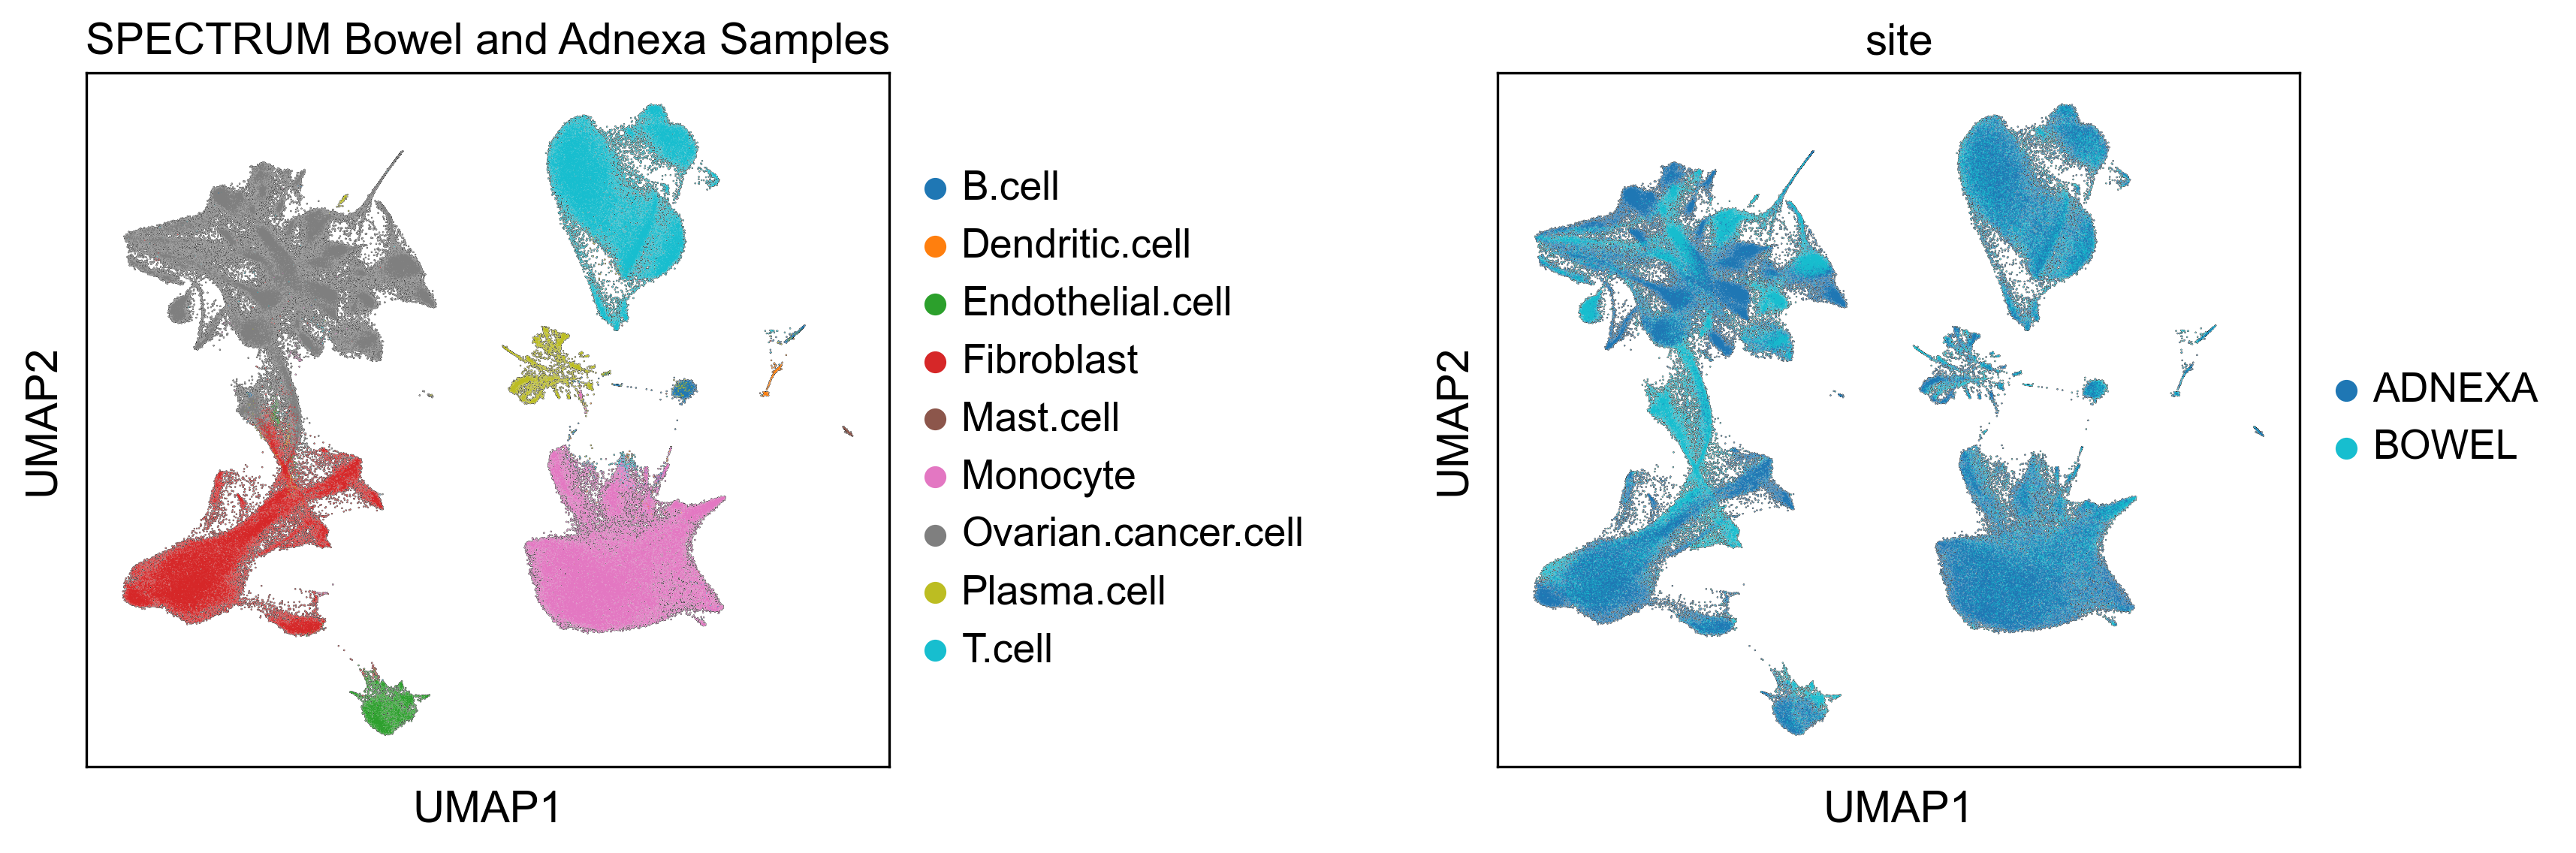

In [87]:
cembed = CellEmbedding(dataset, embed)
adata = cembed.get_adata()
sc.pl.umap(adata,palette="tab10",color=["author_cell_type","site"],
           title=["SPECTRUM Bowel and Adnexa Samples"],add_outline=True,wspace=0.6)

In [38]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [48]:
def phenotype_probability(self, adata, up_phenotype_markers, down_phenotype_markers, target_col="genevector"):
    mapped_components = dict(zip(list(self.data.keys()),self.matrix))
    adata = adata[list(self.data.keys())]
    probs = dict()
    for pheno, markers in up_phenotype_markers.items():
        dists = []
        vector = self.embed.generate_vector(markers)
        if pheno in down_phenotype_markers:
            for g in down_phenotype_markers[pheno]:
                dvector = self.embed.generate_vector(g)
                offset = numpy.subtract(dvector, vector)
                vector = numpy.add(vector,offset)
        ovecs = []
        for oph, ovec in up_phenotype_markers.items():
            if oph != pheno:
                ovec = self.embed.generate_vector(ovec)
                ovecs.append(ovec)
        aovec = numpy.mean(ovecs,axis=0)
        vector = numpy.subtract(vector,aovec)

        for x in tqdm.tqdm(adata.obs.index):
            dist = 1.0 - distance.cosine(mapped_components[x],vector)
            dists.append(dist)
        probs[pheno] = dists
    distribution = []
    celltypes = []
    for k, v in probs.items():
        distribution.append(v)
        celltypes.append(k)
    distribution = list(zip(*distribution))
    classif = []
    probabilities = []
    scaler = StandardScaler()
    probabilities = softmax(scaler.fit_transform(numpy.array(distribution)),axis=1)
    for ct in probabilities:
        assign = celltypes[numpy.argmax(ct)]
        classif.append(assign)
    res = {"distances":distribution, "order":celltypes, "probabilities":probabilities}
    barcode_to_label = dict(zip(list(self.data.keys()), res["probabilities"]))
    ct = []
    probs = collections.defaultdict(list)
    for x in adata.obs.index:
        ctx = res["order"][numpy.argmax(barcode_to_label[x])]
        ct.append(ctx)
        for ph, pb in zip(res["order"],barcode_to_label[x]):
            probs[ph].append(pb)
    adata.obs[target_col] = ct
    return adata

In [50]:
ct = []
for x in adata.obs['author_cell_type']:
    if x in ["Dendritic.cell","Mast.cell"]:
        ct.append("Other")
    else:
        ct.append(x)
adata.obs["celltype"] = ct

In [ ]:
import yaml
with open("references/hgsc_v7_major.yaml", "r") as file:
    markers = yaml.safe_load(file)

annotated_adata = phenotype_probability(cembed, adata,markers,dict())

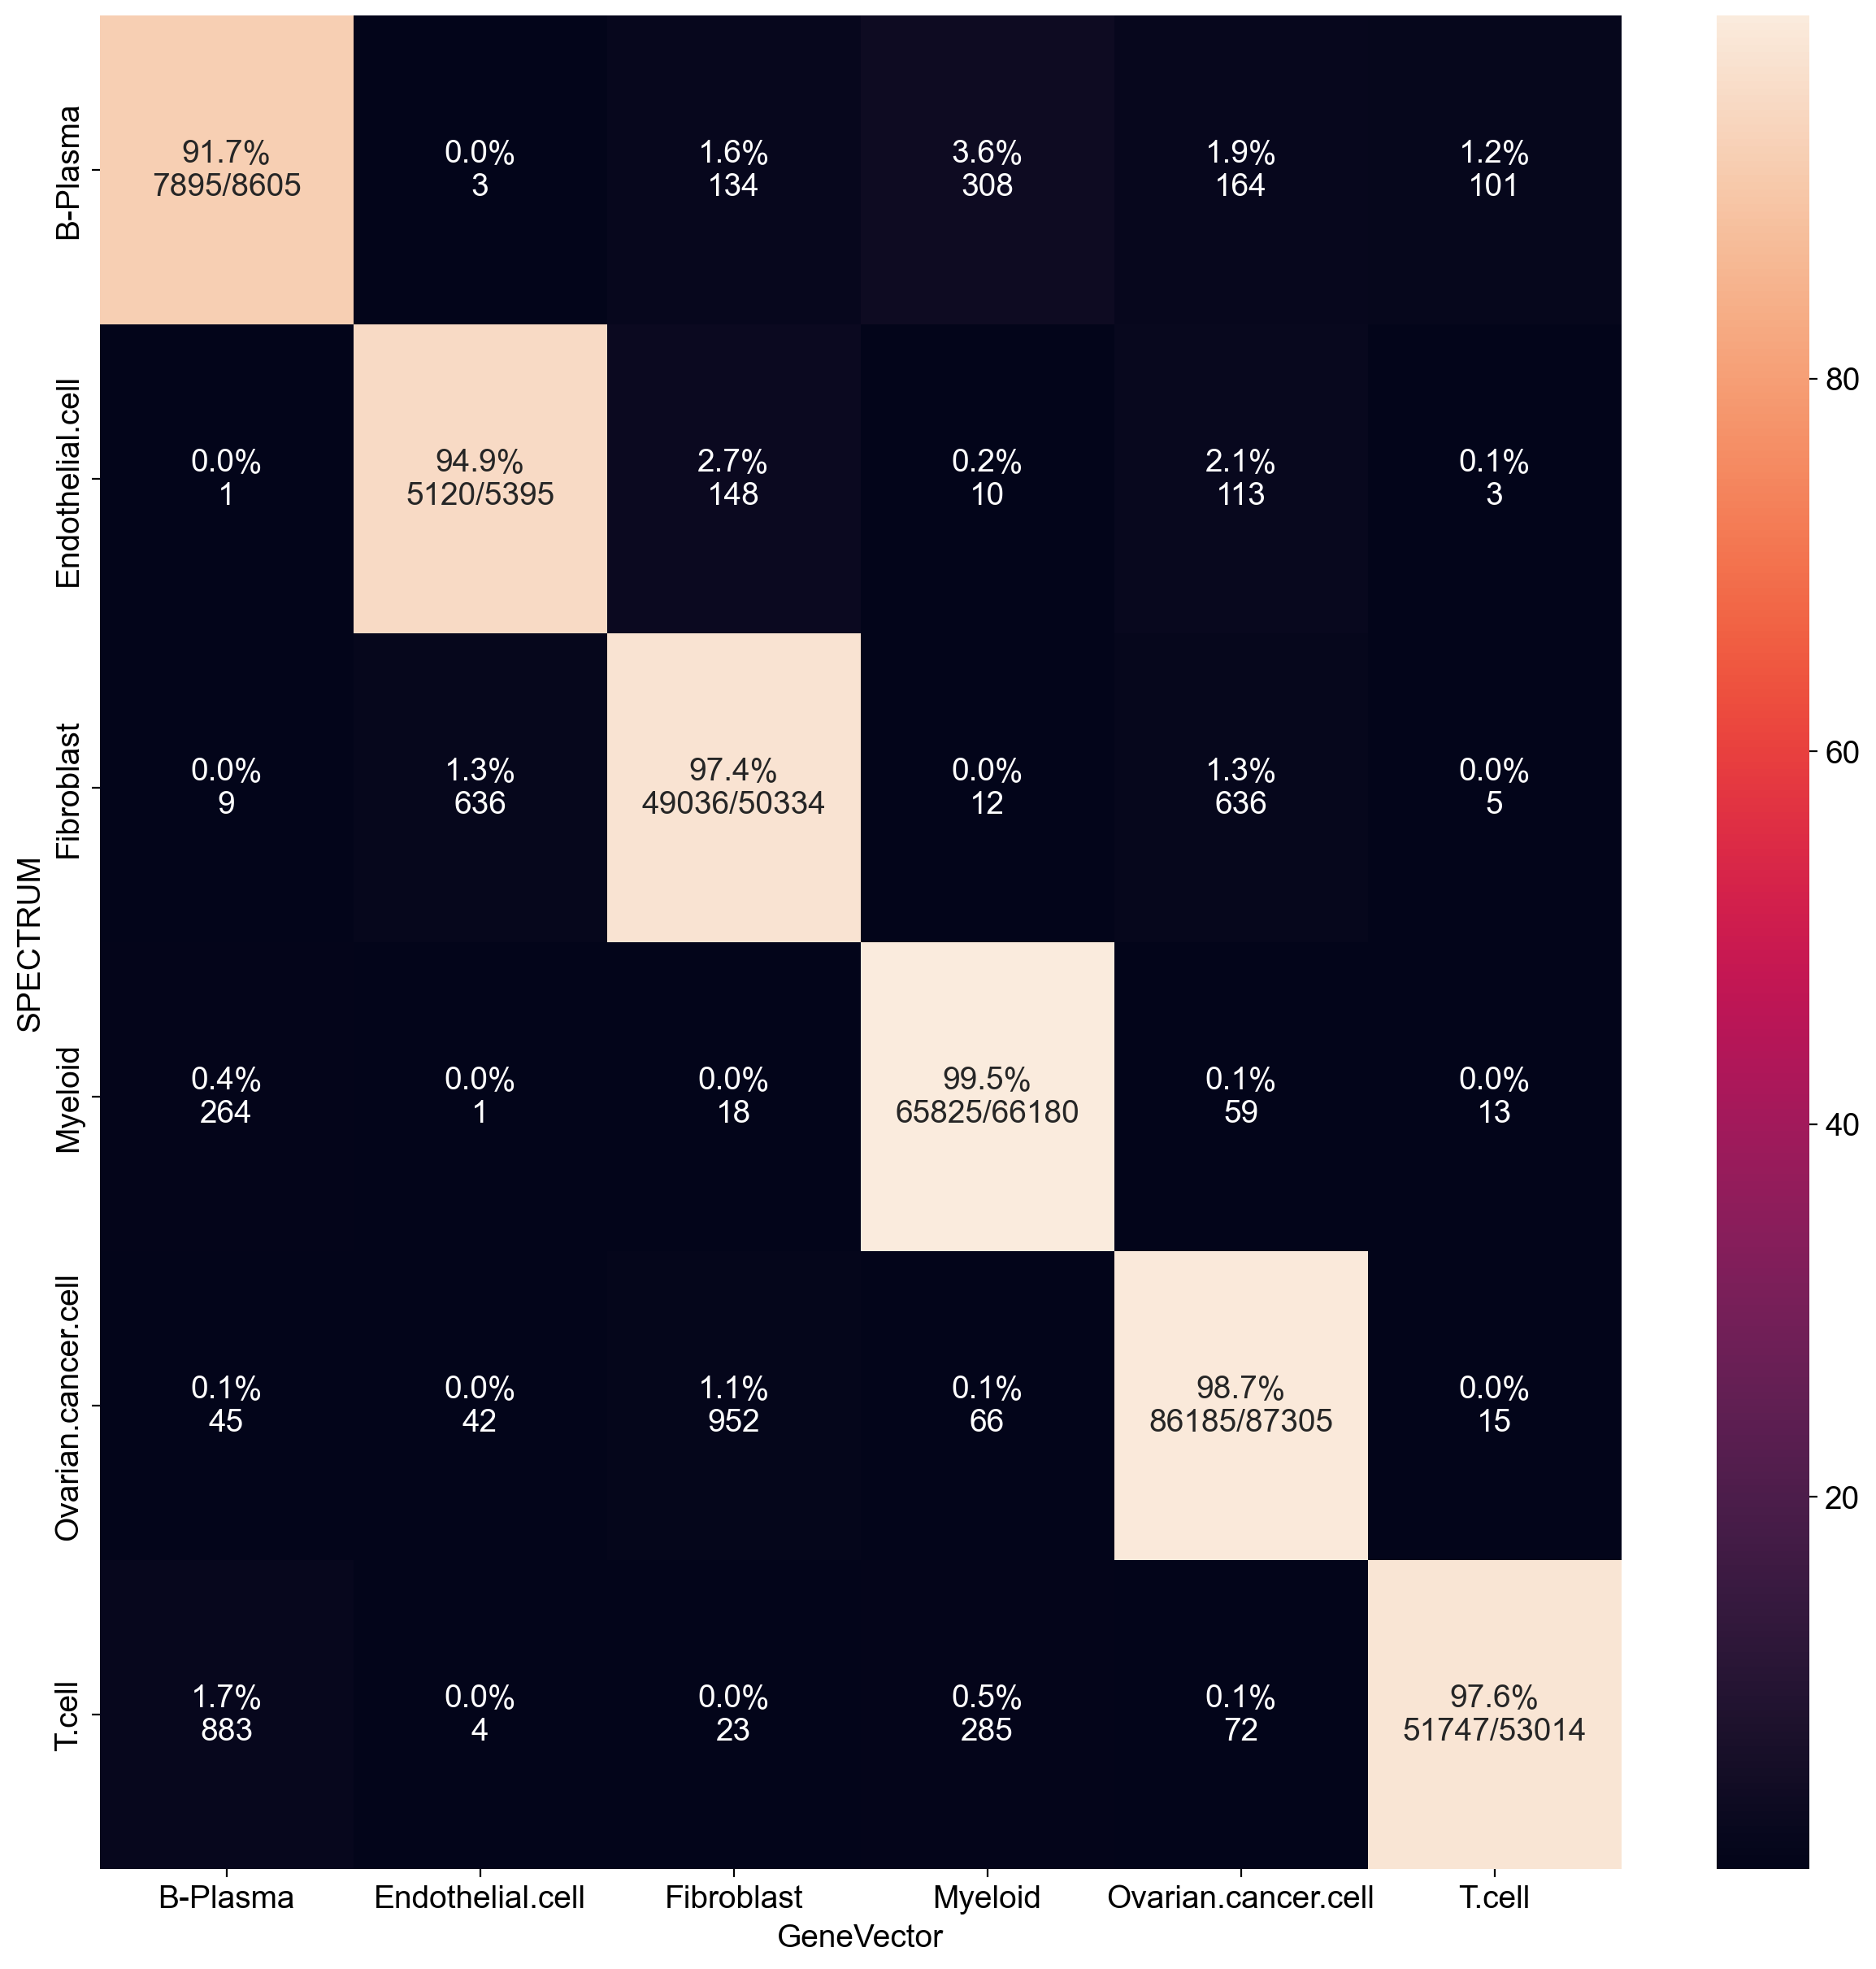

In [504]:
ct = []
for x in annotated_adata.obs["genevector"]:
    if x in ["Dendritic.cell","Mast.cell","Monocyte"]:
        ct.append("Myeloid")
    elif x in ["B.cell","Plasma.cell"]:
        ct.append("B-Plasma")
    else:
        ct.append(x)
annotated_adata.obs["genevector"] = ct

ct = []
for x in annotated_adata.obs["author_cell_type"]:
    if x in ["Dendritic.cell","Mast.cell","Monocyte"]:
        ct.append("Myeloid")
    elif x in ["B.cell","Plasma.cell"]:
        ct.append("B-Plasma")
    else:
        ct.append(x)
annotated_adata.obs["celltype"] = ct

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

gv_ct = annotated_adata.obs["genevector"].tolist()
ca_ct = annotated_adata.obs["celltype"].tolist()
def plot_cm(y_true, y_pred, figsize=(15,15)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm_perc, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'SPECTRUM'
    cm.columns.name = 'GeneVector'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax,annot_kws={"size": 12})
    plt.savefig("/Users/ceglian/spectrum_acc.pdf")

plot_cm(ca_ct,gv_ct)



/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


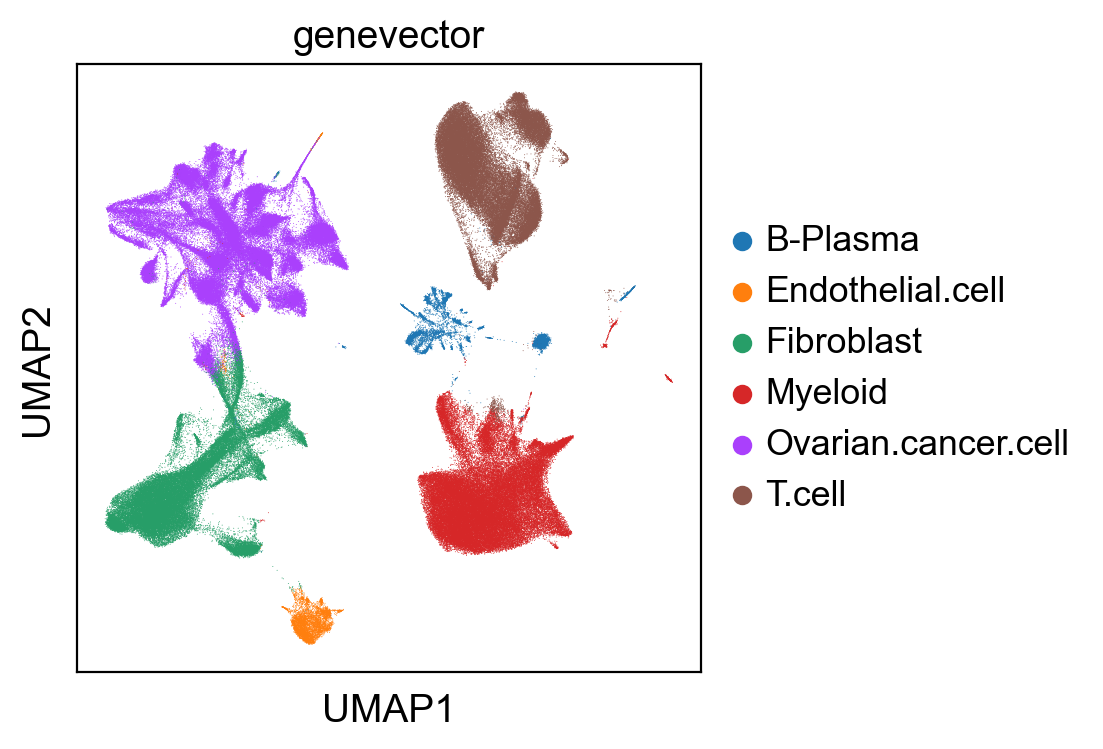

In [38]:
sc.pl.umap(annotated_adata,color="genevector",save="gv_spectrum.pdf")

In [514]:
adata = annotated_adata[annotated_adata.obs["genevector"]=="Ovarian.cancer.cell"]
adata

View of AnnData object with n_obs × n_vars = 87229 × 3000
    obs: 'percent.mt', 'percent.rb', 'doublet', 'author_sample_id', 'S.Score', 'G2M.Score', 'Phase', 'CC.Diff', 'author_cell_type', 'nCount_RNA', 'nFeature_RNA', 'doublet_score', 'cell_id', 'organism_ontology_term_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'disease_ontology_term_id', 'ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'author_tumor_supersite', 'author_tumor_site', 'author_tumor_subsite', 'author_sort_parameters', 'author_therapy', 'author_procedure', 'author_procedure_type', 'is_primary_data', 'site', 'celltype', 'genevector', 'wrong'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'author_cell_type_colors', 'hvg', 'neighbors', 'schema_version', 'title', 'umap', 'site_colors', 'rank_genes_groups', 'dendrogram_author_ce

# Load Cancer Cell Embedding

In [ ]:
dataset = GeneVectorDataset(adata)

In [ ]:
retrain = False
if retrain:
    cmps = GeneVector(dataset,
                      output_file="spectrum_cancer.vec",
                      batch_size=200000,
                      min_pct=0.0,
                      max_pct=0.3,
                      emb_dimension=100)
    cmps.train(10000,threshold=1e-8)

In [ ]:
embed = GeneEmbedding("embeddings/spectrum_cancer.vec", dataset,vector="average")

In [ ]:
cembed = CellEmbedding(dataset, embed)
adata = cembed.get_adata()
sc.pl.umap(adata,palette="tab10",color=["author_cell_type","site"],
           title=["SPECTRUM Bowel and Adnexa Samples"],add_outline=True,wspace=0.6)

# Generate Metagenes

In [515]:
gdata = embed.get_adata(resolution=28.2)
metagenes = embed.get_metagenes(gdata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 269 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


In [1]:
embed.score_metagenes(adata, metagenes)

# Generate Vectors for each Site

In [518]:
subad = adata[adata.obs["site"]=="ADNEXA"]
subbo = adata[adata.obs["site"]=="BOWEL"]

ADNEXA-Ovarian.cancer.cell
ADNEXA-T.cell
ADNEXA-Fibroblast
ADNEXA-Endothelial.cell
ADNEXA-Myeloid
ADNEXA-B-Plasma
BOWEL-Ovarian.cancer.cell
BOWEL-Fibroblast
BOWEL-Endothelial.cell
BOWEL-B-Plasma
BOWEL-Myeloid
BOWEL-T.cell


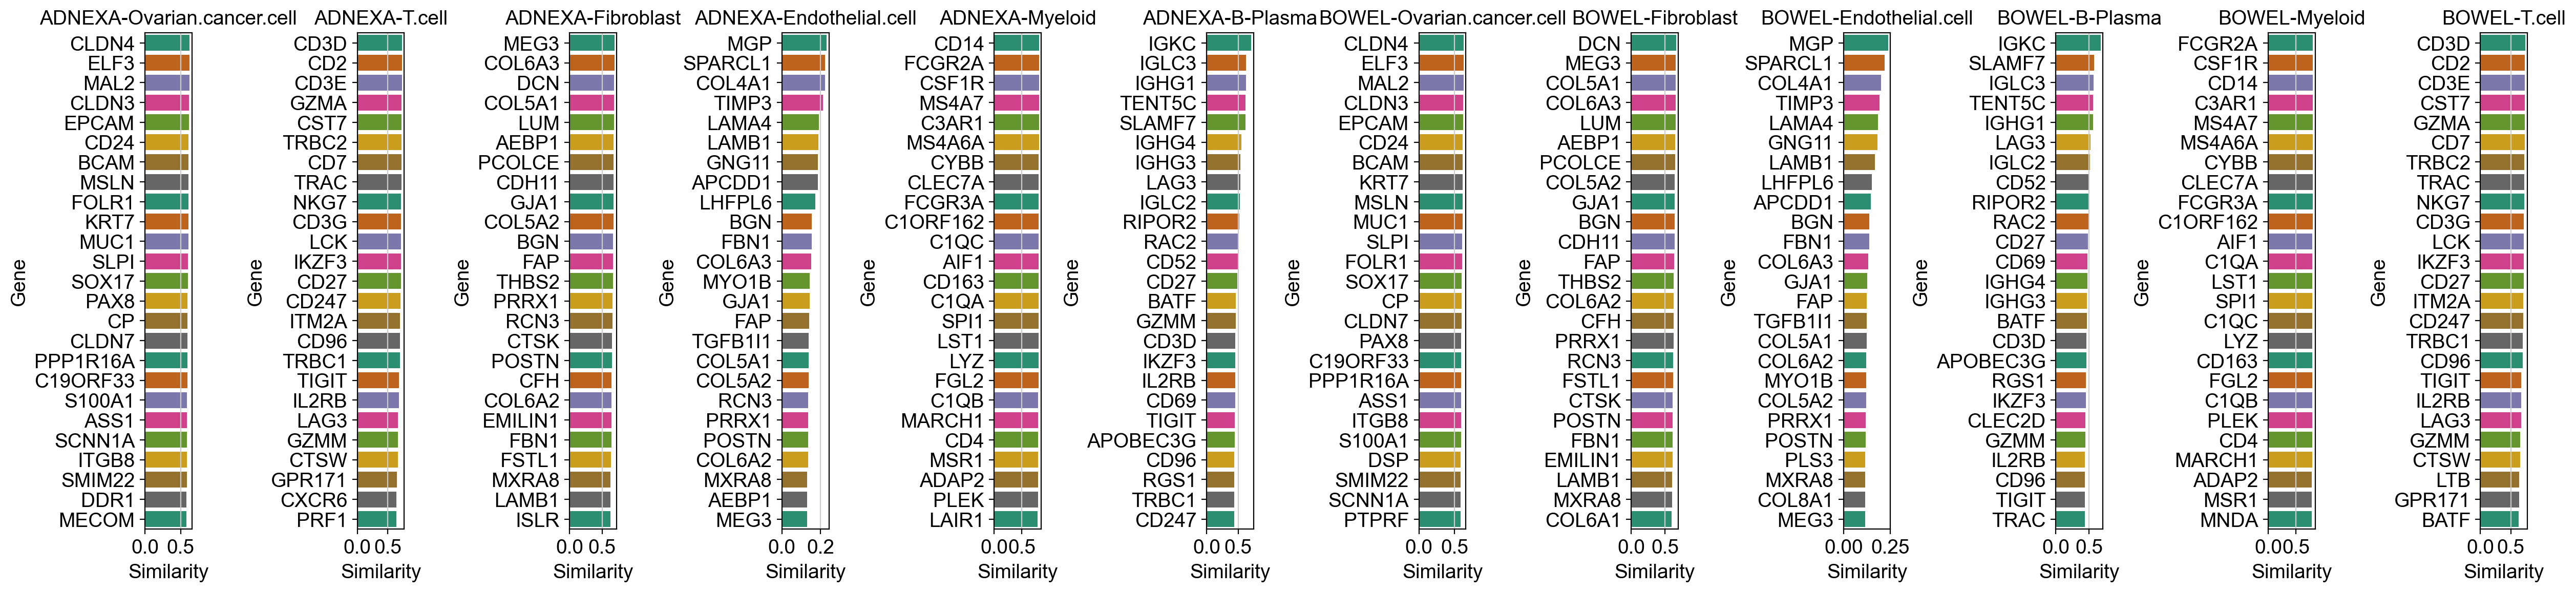

In [523]:
import matplotlib.pyplot as plt
mapped_components = dict(zip(list(cembed.data.keys()),cembed.matrix))
comps = collections.defaultdict(list)
for bc,x,y in zip(annotated_adata.obs.index,annotated_adata.obs["site"],annotated_adata.obs["genevector"]):
    comps[x +"-"+ y].append(mapped_components[bc])
vectors = dict()
mean_vecs = []
for x, vec in comps.items():
    print(x)
    ovecs = []
    vec = numpy.mean(vec,axis=0)
    for oph, ovec in comps.items():
        for o in ovec:
            ovecs.append(o)
    aovec = numpy.average(ovecs,axis=0)
    vector = numpy.subtract(vec,aovec)
    vector = numpy.subtract(vector,cembed.dataset_vector)
    vectors[x] = vector
markers = dict()
fig,ax = plt.subplots(1,12,figsize=(25,6))
i = 0
for x, mvec in vectors.items():
    ct_sig = embed.get_similar_genes(mvec)[:25]
    sns.barplot(data=ct_sig,y="Gene",x="Similarity",palette="Dark2",ax=ax[i])
    ax[i].set_title(x)
    i += 1
fig.tight_layout()

In [ ]:
import matplotlib.pyplot as plt
mapped_components = dict(zip(list(cembed.data.keys()),cembed.matrix))
comps = collections.defaultdict(list)
for bc,x in zip(adata.obs.index,adata.obs["site"]):
    comps[x].append(mapped_components[bc])
vectors = dict()
mean_vecs = []
for x, vec in comps.items():
    print(x)
    ovecs = []
    vec = numpy.mean(vec,axis=0)
    for oph, ovec in comps.items():
        for o in ovec:
            ovecs.append(o)
    aovec = numpy.average(ovecs,axis=0)
    vector = numpy.subtract(vec,aovec)
    vector = numpy.subtract(vector,cembed.dataset_vector)
    vectors[x] = vector
markers = dict()
fig,ax = plt.subplots(1,2,figsize=(8,6))
i = 0
for x, mvec in vectors.items():
    ct_sig = embed.get_similar_genes(mvec)[:25]
    sns.barplot(data=ct_sig,y="Gene",x="Similarity",palette="Dark2",ax=ax[i])
    ax[i].set_title(x)
    i += 1
fig.tight_layout()

# Find Metagenes similar to Adnexa - Bowel (Vector Arithmetic)

In [525]:
from scipy.spatial import distance
res = numpy.subtract(vectors["ADNEXA-Ovarian.cancer.cell"],vectors["BOWEL-Ovarian.cancer.cell"])
mgs_down = dict()
distances = dict()
for mg, genes in metagenes.items():
    mgvec = embed.generate_vector(genes)
    dist = 1.0 - distance.cosine(res,mgvec)
    distances[mg] = dist
sorted_x = list(reversed(sorted(distances.items(), key=lambda kv: kv[1])))
for mg, dist in sorted_x[:5]:
    print(mg, dist, metagenes[mg])
    mgs_down[mg] = metagenes[mg]

11 0.4773170930944942 ['ANKRD65', 'LYPD1', 'KIF9', 'PPP1R9A', 'BEX2', 'ESRP1', 'EPPK1', 'PSAT1', 'AIF1L', 'EMX2OS', 'MYEF2', 'HOMER2', 'PRSS8', 'CDH1', 'ITGB4', 'KCNK15', 'FXYD3', 'KLK6', 'KLK7', 'KLK11', 'EPS8L1', 'PRAME']
13 0.44752101134939326 ['LPAR3', 'LEMD1', 'LONRF2', 'LYPD6B', 'C2ORF88', 'SHROOM3', 'SLC44A4', 'TMEM139', 'FAM84B', 'FAM83H', 'SCX', 'TMOD1', 'LGR4', 'PKP2', 'AQP5', 'ERBB3', 'RAB3IP', 'NPAS3', 'GRB7', 'PLPP2', 'MYH14', 'KLK10']
160 0.40033648307652014 ['KAZN', 'GALNT3', 'ANXA3', 'C6ORF132', 'ESR1', 'TM7SF2', 'APOA1', 'PARD6B', 'CTXN1']
54 0.3865101908731525 ['DHCR24', 'SELENBP1', 'S100A1', 'CHI3L1', 'MEIS1', 'MECOM', 'ID4', 'DDR1', 'WT1', 'SNCG', 'EMX2', 'SCNN1A', 'SLC9A3R2', 'SMIM22', 'MUC16', 'ISYNA1']
47 0.38420294090994345 ['MEX3A', 'DAPL1', 'NECTIN3', 'AMOTL2', 'NSG1', 'UCHL1', 'PEG10', 'PODXL', 'FZD3', 'ZNF704', 'EFNB2', 'STON2', 'SNHG19', 'GPRC5B', 'CDH2', 'ADAMTS1']


# Find Metagenes similar to Bowel - Adnexa

In [527]:
from scipy.spatial import distance
res = numpy.subtract(vectors["BOWEL-Ovarian.cancer.cell"],vectors["ADNEXA-Ovarian.cancer.cell"])
mgs_up = dict()
distances = dict()
for mg, genes in metagenes.items():
    mgvec = embed.generate_vector(genes)
    dist = 1.0 - distance.cosine(res,mgvec)
    distances[mg] = dist
sorted_x = list(reversed(sorted(distances.items(), key=lambda kv: kv[1])))
for mg, dist in sorted_x[:5]:
    print(mg, dist, metagenes[mg])
    mgs_up[mg] = metagenes[mg]

10 0.5627224293530682 ['OLFML3', 'VAMP5', 'FN1', 'FILIP1L', 'BASP1', 'DAB2', 'VCAN', 'RHOBTB3', 'TGFBI', 'GPNMB', 'TMEM176B', 'HTRA1', 'CLEC2B', 'RGCC', 'MMP14', 'MMP2', 'SERPINF1', 'PMP22', 'IGFBP4', 'TUBB6', 'MAFB', 'PLAUR', 'EMP3']
42 0.5161447260348727 ['CTSK', 'CFH', 'ANTXR1', 'COL5A2', 'COL6A3', 'GJA1', 'AEBP1', 'PCOLCE', 'LAMB1', 'BGN', 'BMP1', 'CERCAM', 'COL5A1', 'LUM', 'DCN', 'MEG3', 'RCN3']
68 0.45718972702446303 ['PDPN', 'ID3', 'VCAM1', 'ECM1', 'OLFML2B', 'EPAS1', 'HEG1', 'LXN', 'RARRES1', 'CXCL12', 'THBS1', 'COPZ2', 'COLEC12', 'SULF2']
88 0.454362602233058 ['PRRX1', 'EMILIN1', 'FAP', 'COL8A1', 'SPON2', 'LOX', 'THBS2', 'IGFBP6', 'POSTN', 'FBN1', 'ISLR', 'CDH11', 'MMP11']
116 0.45148840423939673 ['GLRX', 'CDKN1A', 'TENT5A', 'DSE', 'TMEM176A', 'NRP1', 'PLAU', 'PHLDA1', 'SPRED1', 'MAF', 'AXL']


# GSEA Enrichment of Metagenes

In [ ]:
import pandas
sns.set(font_scale=0.9)
import gseapy as gp
enrc = collections.defaultdict(dict)
terms = set()
mgs = []
for mg, genes in mgs_up.items():
    enr = gp.enrichr(gene_list=genes,
                     gene_sets=['MSigDB_Hallmark_2020'],
                     organism='Human', 
                     description='test_name',
                     outdir='test/enrichr_kegg',
                     cutoff=0.001 
                    )    
    mgs.append(mg)
    for x,y in zip(enr.res2d["Term"],enr.res2d["Combined Score"]):
        if y > 0:
            enrc[mg][x] = y
            terms.add(x)
mat = []
for term in terms:
    row = []
    for mg in mgs:
        if term in enrc[mg]:
            row.append(enrc[mg][term])
        else:
            row.append(0.0)
    mat.append(row)
print(mat)
df = pandas.DataFrame(numpy.array(mat),columns=mgs,index=terms).T
fig, ax = plt.subplots(1,1,figsize=(12,7))
sns.heatmap(df,yticklabels=True,xticklabels=True,ax=ax, vmax=500,cmap="viridis")
ax.set_title("Hallmark Combined Enrichment Score")
fig.tight_layout()

In [ ]:
import matplotlib.pyplot as plt
import collections
import numpy
import seaborn as sns
import pandas
sns.set(font_scale=0.9)
import gseapy as gp
for p in set(adata.obs["patient"]):
    sub = adata[adata.obs["patient"]==p]
    mapped_components = dict(zip(list(cembed.data.keys()),cembed.matrix))
    comps = collections.defaultdict(list)
    for bc,x in zip(sub.obs.index,sub.obs["site"]):
        comps[x].append(mapped_components[bc])
    vectors = dict()
    mean_vecs = []
    for x, vec in comps.items():
        print(x)
        ovecs = []
        vec = numpy.mean(vec,axis=0)
        for oph, ovec in comps.items():
            for o in ovec:
                ovecs.append(o)
        aovec = numpy.average(ovecs,axis=0)
        vector = numpy.subtract(vec,aovec)
        vector = numpy.subtract(vector,cembed.dataset_vector)
        vectors[x] = vector
    res = numpy.subtract(vectors["BOWEL"],vectors["ADNEXA"])
    mgs_up = dict()
    distances = dict()
    for mg, genes in metagenes.items():
        mgvec = embed.generate_vector(genes)
        dist = 1.0 - distance.cosine(res,mgvec)
        distances[mg] = dist
    sorted_x = list(reversed(sorted(distances.items(), key=lambda kv: kv[1])))
    for mg, dist in sorted_x[:15]:
        print(mg, dist, metagenes[mg])
        mgs_up[mg] = metagenes[mg]

    enrc = collections.defaultdict(dict)
    terms = set()
    mgs = []
    for mg, genes in mgs_up.items():
        enr = gp.enrichr(gene_list=genes,
                        gene_sets=['MSigDB_Hallmark_2020'],
                        organism='Human', 
                        description='test_name',
                        outdir='test/enrichr_kegg',
                        cutoff=0.001 
                        )    
        mgs.append(mg)
        for x,y in zip(enr.res2d["Term"],enr.res2d["Combined Score"]):
            if y > 0:
                enrc[mg][x] = y
                terms.add(x)
    mat = []
    for term in terms:
        row = []
        for mg in mgs:
            if term in enrc[mg]:
                row.append(enrc[mg][term])
            else:
                row.append(0.0)
        mat.append(row)
    print(mat)
    df = pandas.DataFrame(numpy.array(mat),columns=mgs,index=list(terms)).T
    fig, ax = plt.subplots(1,1,figsize=(12,7))
    sns.heatmap(df,yticklabels=True,xticklabels=True,ax=ax, vmax=500,cmap="viridis")
    ax.set_title("Hallmark Combined Enrichment Score - {}".format(p))
    fig.tight_layout()
    # plt.savefig("/Users/ceglian/bowel_to_adnexa.svg")